In [1]:
from __future__ import print_function, division
import sys
sys.path.insert(0, 'lib')
import numpy as np
import random
import pydicom
import os
import matplotlib.pyplot as plt
import pickle
import math
import pydicom
from utils import make_giant_mat, make_dictionary, make_echo_dict
from shutil import copyfile
import nibabel as nib
import scipy.ndimage as ndimage
from scipy.stats import pearsonr, spearmanr

from difference_map_utils import make_difference
from cluster_utils import threshold_diffmaps, strip_empty_lines, resize
from inference_utils import run_inference
from make_inference_csv import *
from compare_segmentations import get_dice_scores, get_jaccard_indices, compare_region_means, compare_region_changes



Using TensorFlow backend.


In [ ]:
img_dir = '/data/kevin_data/images/YR4/9435250/T2'
visualization = np.load('/data/kevin_data/qmetric/t2_projected/9435250_4.npy')

# Find the physical area covered by the cartilage plate
### Find the slice spacing and slice thickness
f = np.sort(os.listdir(img_dir))[0]
f = os.path.join(img_dir,f)
dcm = pydicom.read_file(f)
slice_thickness = dcm.SliceThickness
slice_spacing = dcm.SpacingBetweenSlices
pixel_spacing = dcm.PixelSpacing[0]
manufacturer = dcm.Manufacturer

temp = np.copy(visualization)
for i in np.argwhere(np.isnan(temp)): 
        temp[tuple(i)]=0
        
temp = strip_empty_lines(temp)
num_cartilage_slices = temp.shape[0]
row_distance = (num_cartilage_slices * slice_thickness) + ((num_cartilage_slices - 1) * slice_spacing)

### Calculate the anterior-posterior distance of the cartilage plate
R = 20*pixel_spacing

angular_bin = 5
full_circumference = 2*R*np.pi
circle_percent = angular_bin*temp.shape[1]/360
column_distance = full_circumference*circle_percent
column_distance

In [ ]:
root = '/data/kevin_data/predicted/segmentations_refined/'
for f in os.listdir(root):
    if f[-4:]=='.npy':
        
        seg_file = os.path.join(root,f)
        s = np.load(seg_file)
        toshow = np.sum(s[:,:,50:400], axis = -2)
        toshow = resize(toshow,(100,100))
        plt.imshow(toshow>0)
        plt.show()

In [ ]:
print(pydicom.read_file('/data/kevin_data/images/YR4/9003126/T2/192').SliceThickness)
print(pydicom.read_file('/data/kevin_data/images/YR4/9003126/T2/192').SpacingBetweenSlices)
pydicom.read_file('/data/kevin_data/images/YR4/9003126/T2/192')


thick_list = []
spacing_list = []
manufacturer_list = []
pixel_list = []
root = '/data/kevin_data/images/YR4/'
for d in os.listdir(root):
    if '.' not in d:
        f = np.sort(os.listdir(os.path.join(root,d,'T2/')))[0]
        f = os.path.join(root,d,'T2',f)
        dcm = pydicom.read_file(f)
        thick_list.append(dcm.SliceThickness)
        spacing_list.append(dcm.SpacingBetweenSlices)
        pixel_list.append(dcm.PixelSpacing)
        manufacturer_list.append(dcm.Manufacturer)
                    
                    
plt.hist(thick_list)
plt.show()
plt.hist(spacing_list)
plt.show()
print(np.unique(manufacturer_list))
print(np.unique(pixel_list))

In [2]:
def make_projection_proportional(projection_dict):
    '''
    projection_dict['t2_projection'] = 2D numpy array with T2 map projection
    
    projection_dict['row_distance'] =  (float) physical distaince (in units of mm) for the medial-lateral width of the knee joint's cartilage
    
    projection_dict['column_distance'] (float) physical distance (in units of mm) for the anterior-posterior width of the knee joint's cartilage
    '''
    projection = projection_dict['t2_projection']
    projection = resize(projection, (np.round(projection_dict['row_distance']), np.round(projection_dict['column_distance'])))
    return projection

def calculate_lesion_area(timepoint1, 
                          timepoint2,
                          value_threshold=None,
                          sigma_multiple=None,
                          area_value_threshold = None,
                          area_percent_threshold=None,
                          display=False,):
    
    assert len(timepoint1)==len(timepoint2), "timepoint1 and timepoint2 need to be same length"
    
    lesion_percent_list = []
    
    
    for i in range(len(timepoint1)):

        with open(timepoint1[i], 'rb') as handle:
            projection1_dict = pickle.load(handle)
            
        with open(timepoint2[i], 'rb') as handle:
            projection2_dict = pickle.load(handle)
            
        projection1 = make_projection_proportional(projection1_dict)
        projection2 = make_projection_proportional(projection2_dict)
        last_col = np.min([projection1.shape[1],projection2.shape[1]])
        
        projection1 = projection1[:,0:last_col-1]
        projection2 = projection2[:,0:last_col-1]
        plt.imshow(projection1)
        plt.show()
        print(projection2.shape)
        plt.imshow(projection2)
        plt.show()
            
#         projection1 = np.load(timepoint1[i])
#         projection2 = np.load(timepoint2[i])
        dif, mask = make_difference(projection2,projection1)
        plt.imshow(dif)
        plt.show()
        plt.imshow(mask)
        plt.show()
        
        dif = strip_empty_lines(dif)
        mask = strip_empty_lines(mask)
        
        dmap,m = threshold_diffmaps(dif, 
                                    mask, 
                                    value_threshold=value_threshold,
                                    sigma_multiple = sigma_multiple,
                                    one_sided = 1,
                                    area_value_threshold = area_value_threshold,
                                    area_fraction_threshold = None,
                                    area_percentile_threshold = None,#80, 
                                    plot = False)
        
        lesion_percent = np.sum(dmap!=0)/np.sum(m)
        lesion_percent_list.append(lesion_percent)
        
        if display:
            toshow = np.copy(m)
            toshow = (toshow>.5)*1
            toshow[dmap!=0]=2
            plt.imshow(toshow)
            plt.title("Lesion Percentage:" + str(lesion_percent))
            plt.show()
            
    return lesion_percent_list
            
      

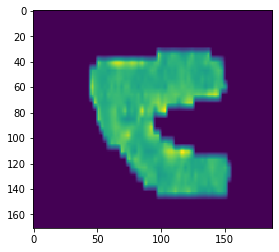

(146, 188)


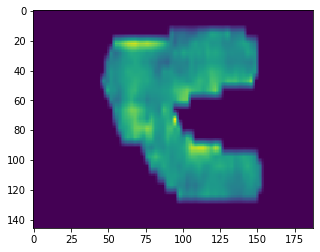

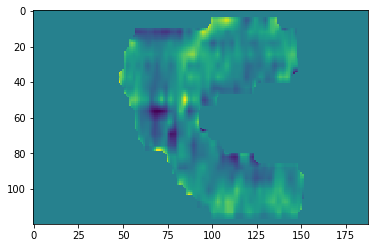

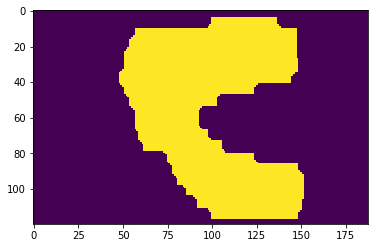

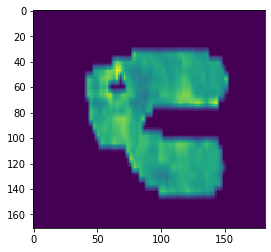

(171, 182)


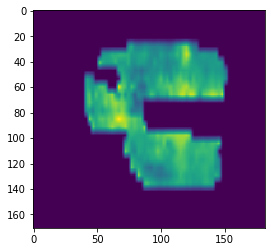

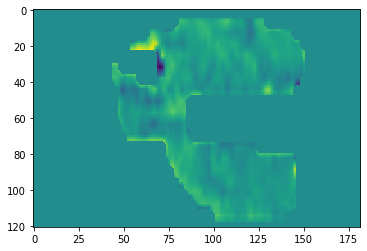

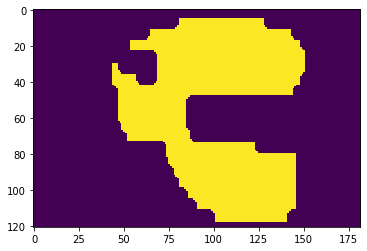

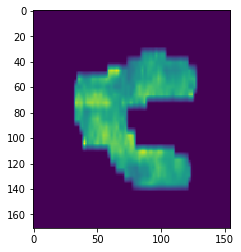

(171, 155)


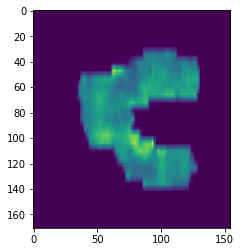

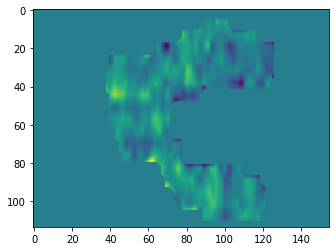

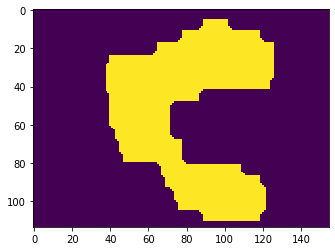

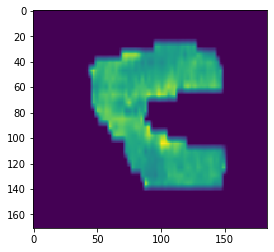

(171, 184)


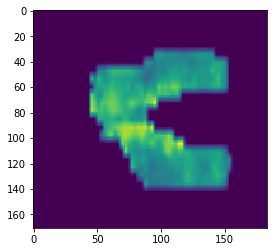

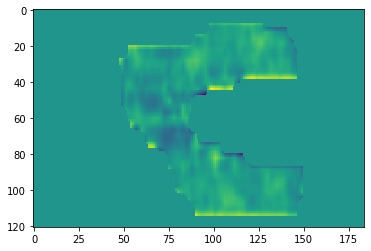

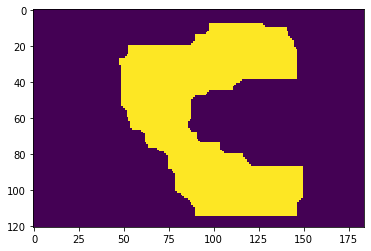

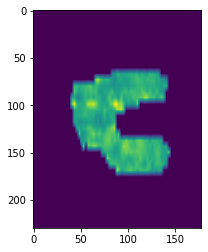

(146, 178)


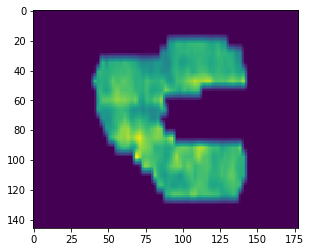

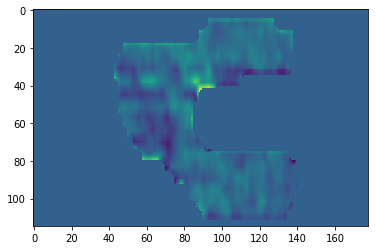

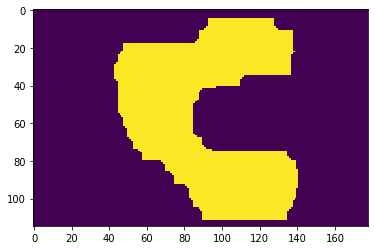

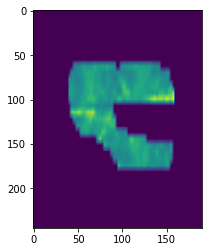

(146, 190)


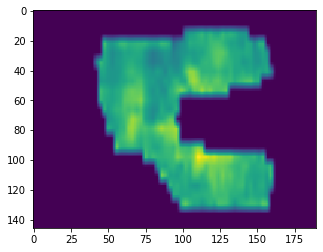

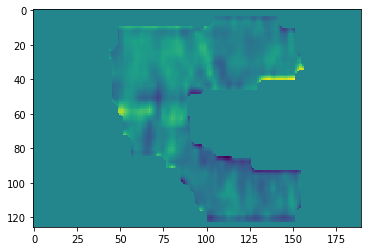

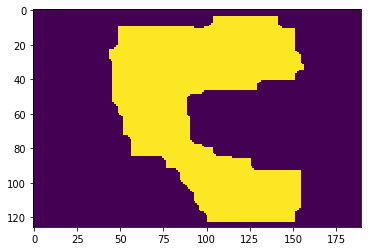

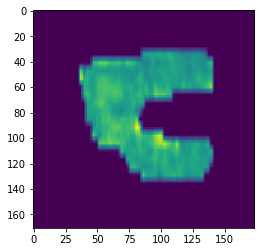

(146, 174)


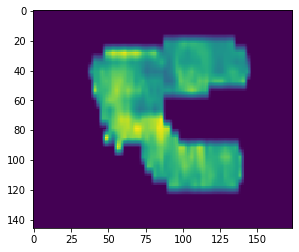

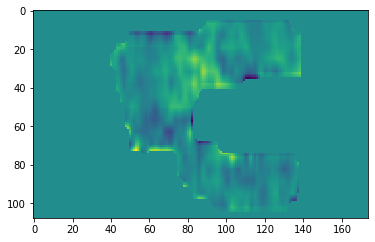

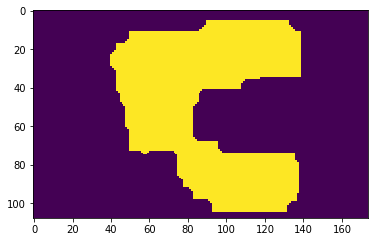

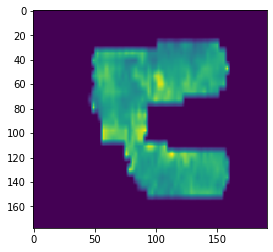

(184, 191)


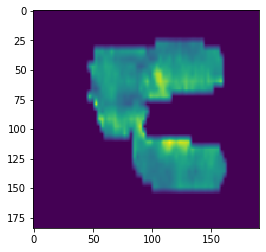

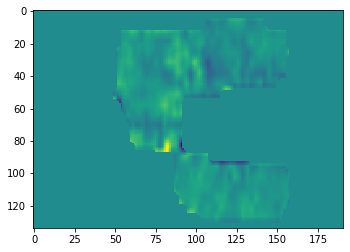

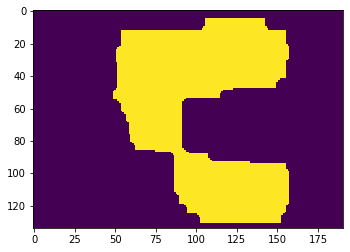

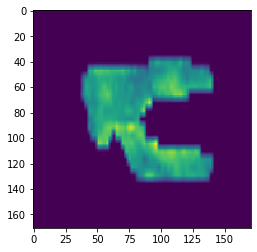

(171, 171)


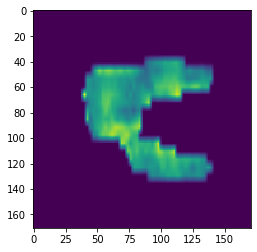

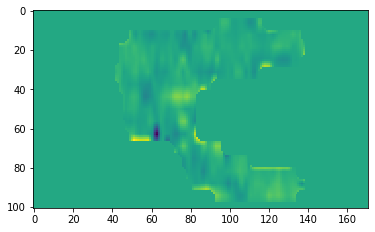

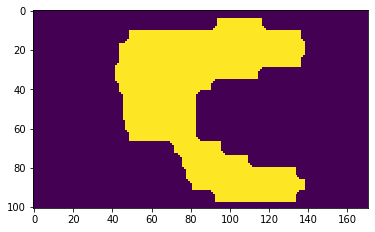

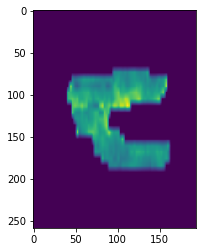

(146, 194)


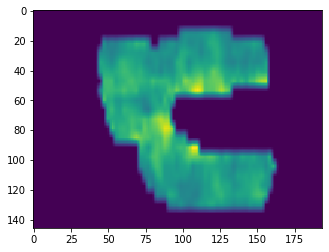

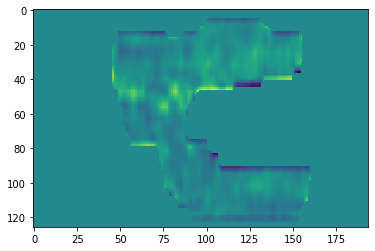

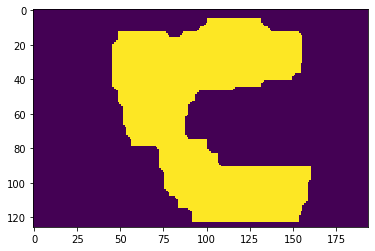

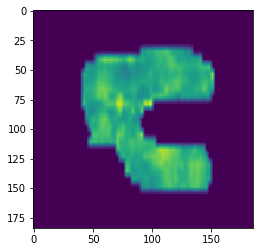

(146, 186)


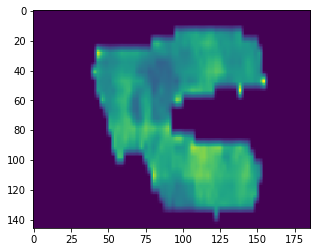

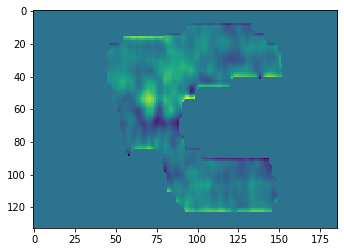

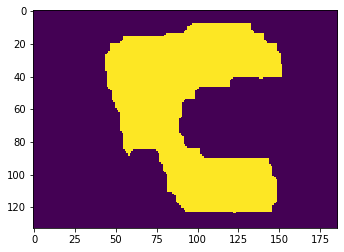

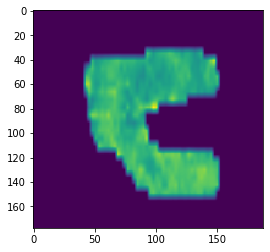

(171, 188)


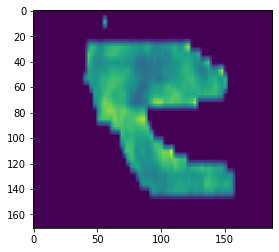

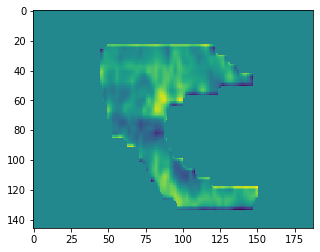

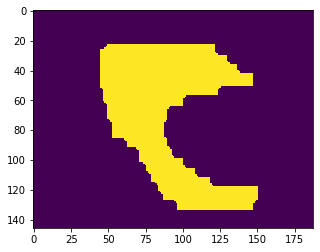

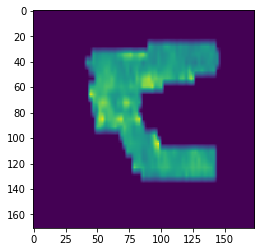

(146, 174)


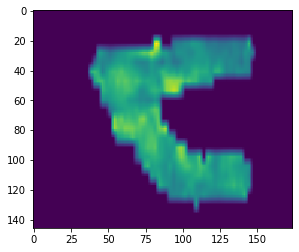

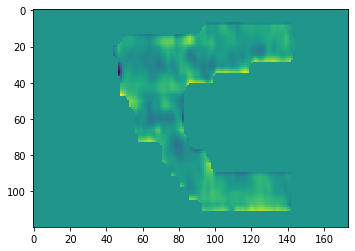

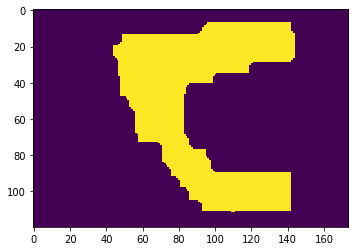

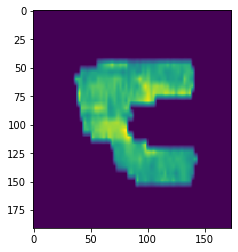

(146, 174)


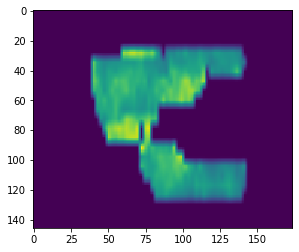

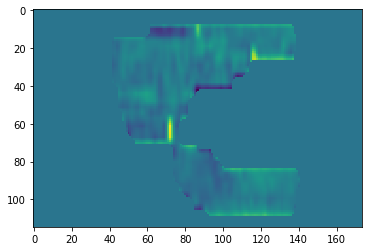

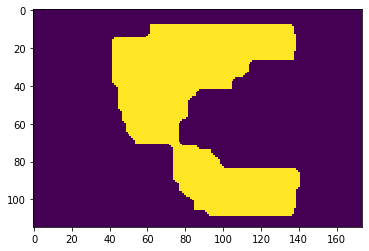

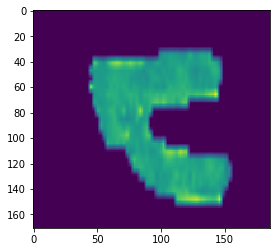

(146, 186)


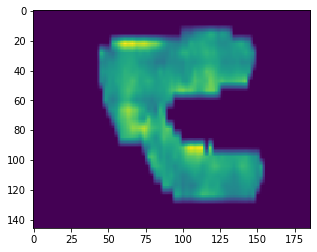

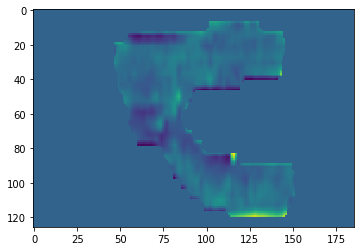

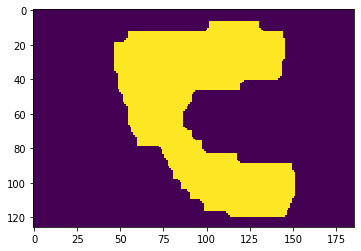

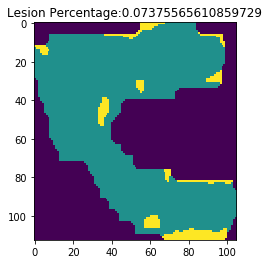

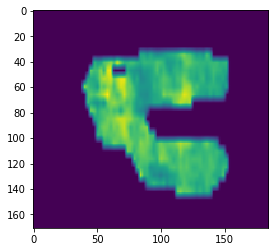

(171, 185)


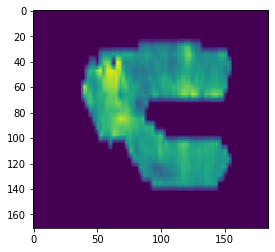

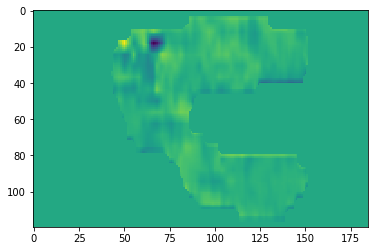

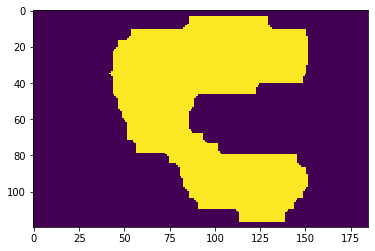

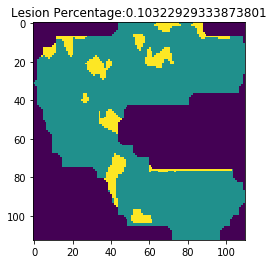

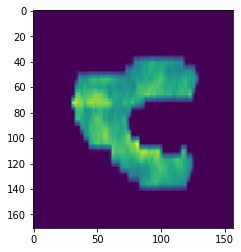

(171, 157)


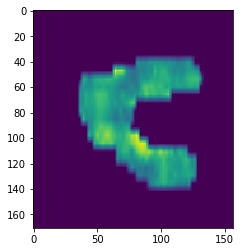

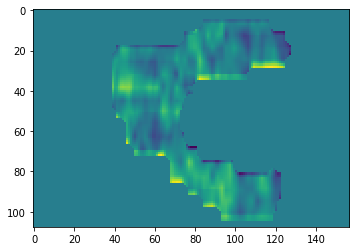

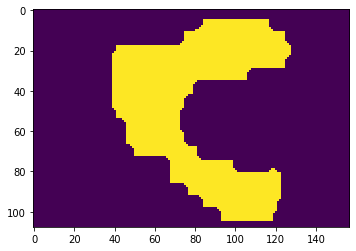

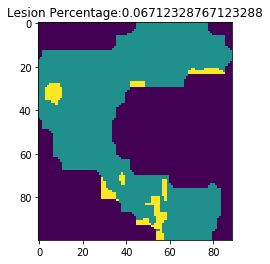

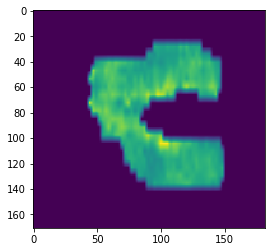

(171, 182)


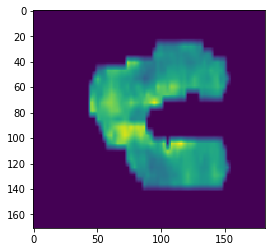

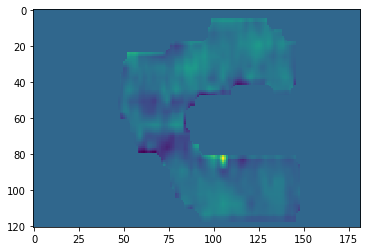

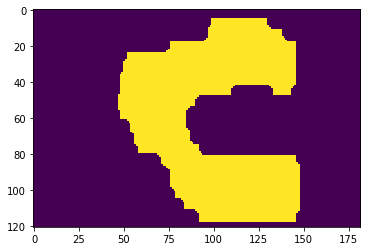

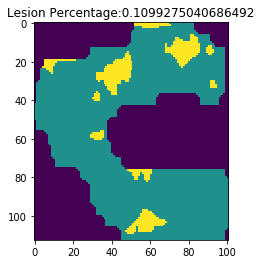

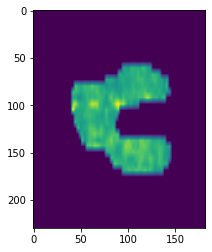

(146, 182)


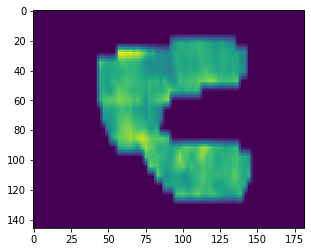

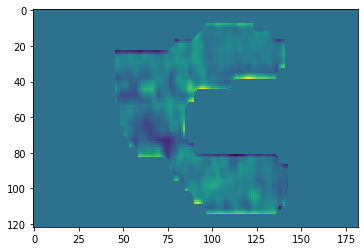

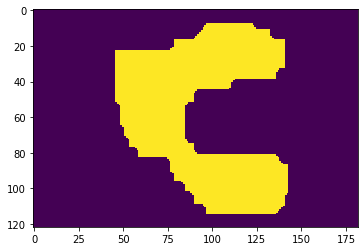

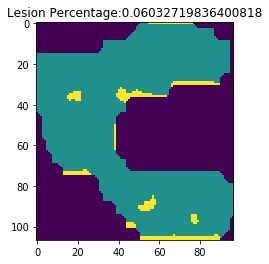

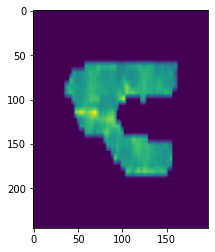

(146, 197)


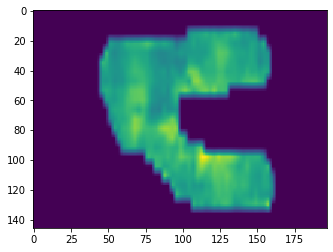

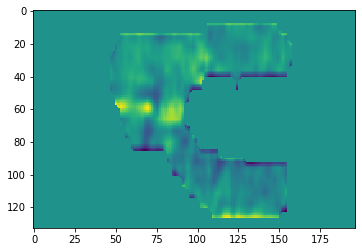

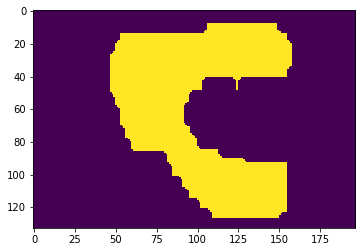

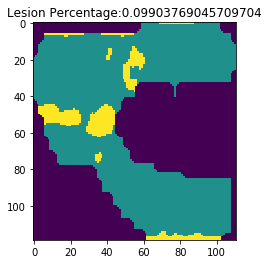

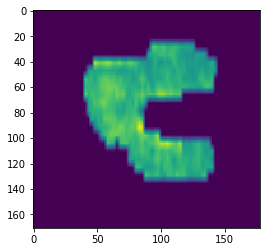

(146, 178)


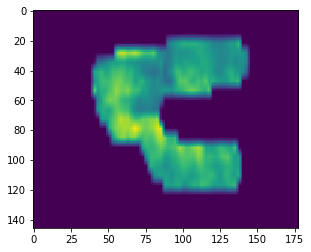

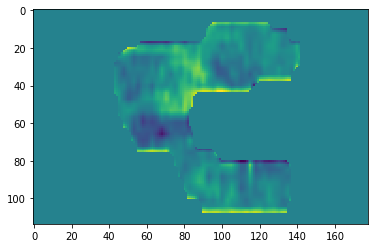

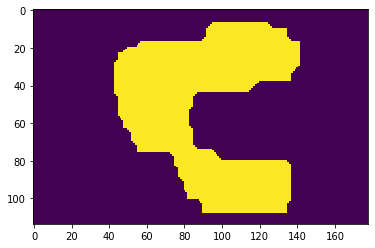

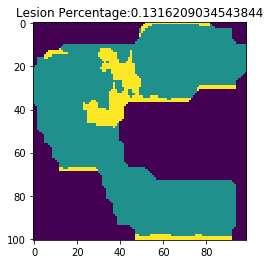

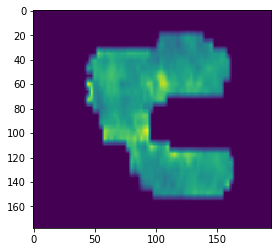

(184, 195)


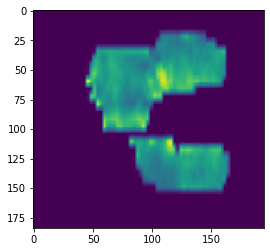

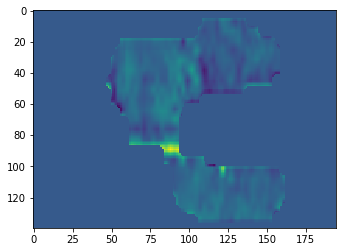

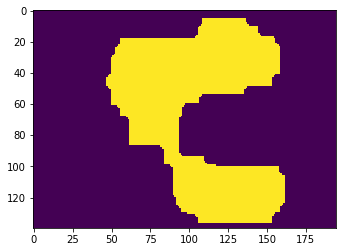

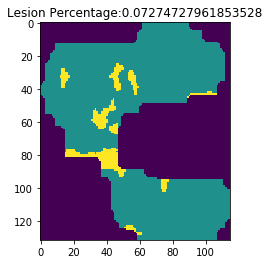

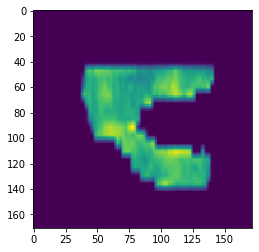

(171, 172)


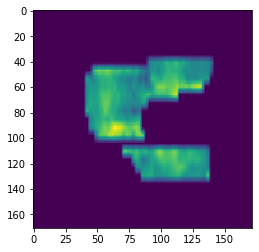

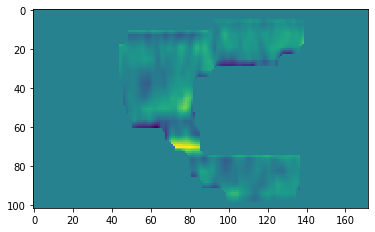

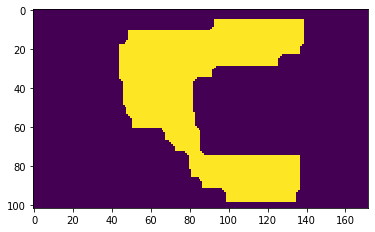

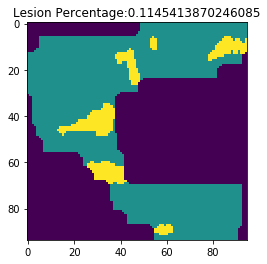

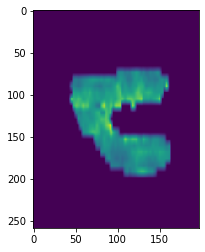

(146, 197)


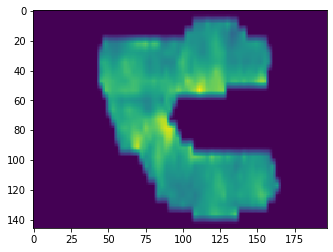

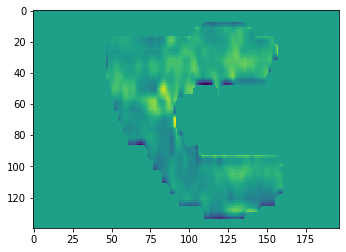

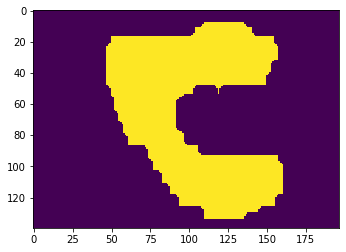

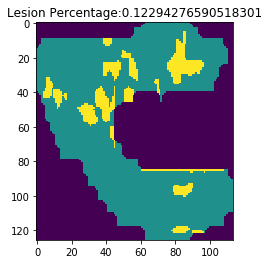

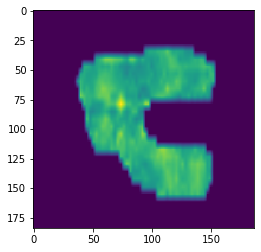

(146, 187)


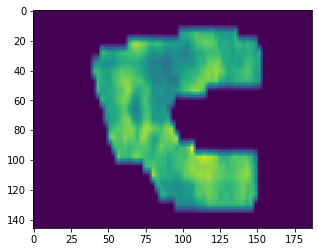

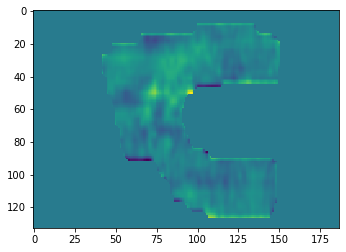

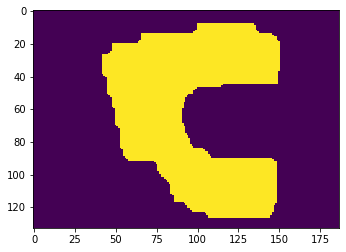

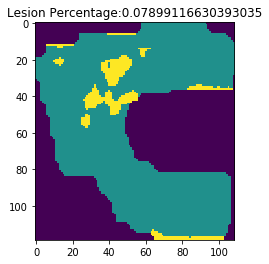

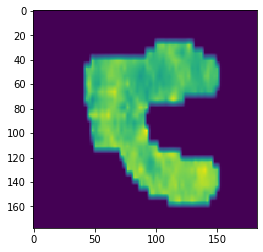

(171, 183)


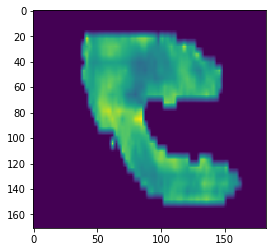

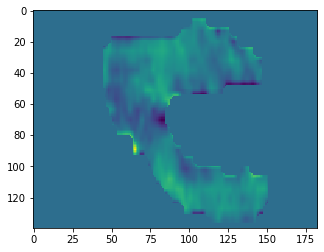

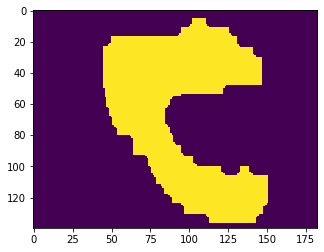

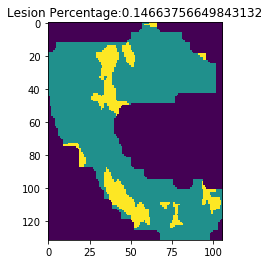

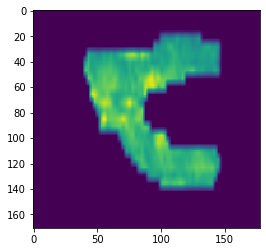

(146, 178)


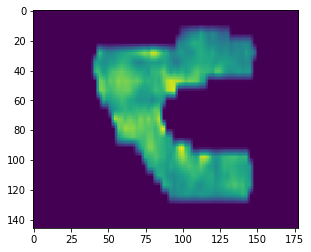

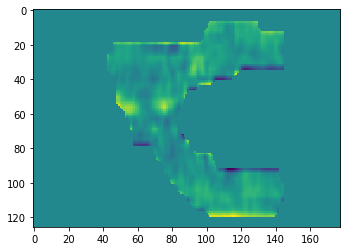

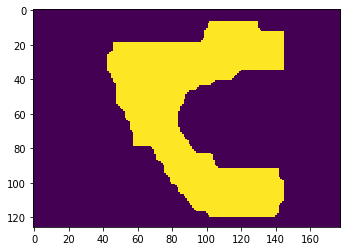

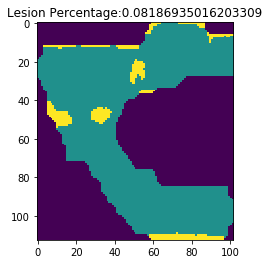

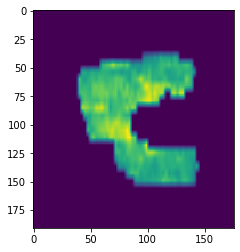

(146, 176)


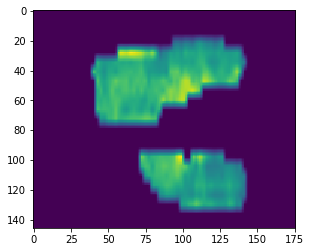

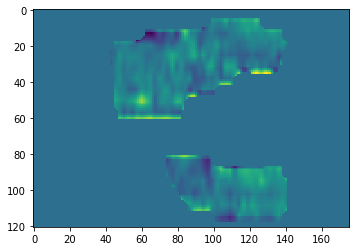

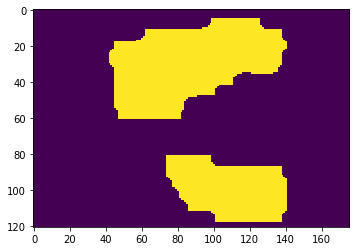

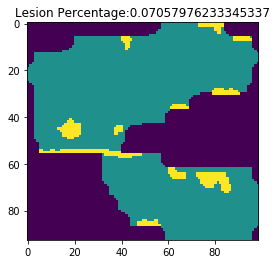

In [9]:
sm_list = np.arange(.5,2.5,.2)
apt_list = np.arange(.01,.05,.005)
corr_list = []
for sm in [1]:#sm_list:
    for apt in [.01]:#apt_list:

        root = '/data/kevin_data/qmetric/t2_projected'
        t1 = np.sort([os.path.join(root,file) for file in os.listdir(root) if file.endswith("4.npy.pickle")])
        t2 = np.sort([os.path.join(root,file) for file in os.listdir(root) if file.endswith("8.npy.pickle")])

        qmetric = calculate_lesion_area(timepoint1=t1,
                                        timepoint2=t2,
                                        value_threshold = 9,
                                        area_value_threshold = 12.4,
#                                         area_percent_threshold = apt, 
#                                         sigma_multiple = sm,
                                       display= False)

        root = '/data/kevin_data/predicted/t2_projected'
        t1 = np.sort([os.path.join(root,file) for file in os.listdir(root) if file.endswith("4.npy.pickle")])
        t2 = np.sort([os.path.join(root,file) for file in os.listdir(root) if file.endswith("8.npy.pickle")])

        pred = calculate_lesion_area(timepoint1=t1,
                                     timepoint2=t2, 
                                     value_threshold = 9,
                                     area_value_threshold = 12.4,
#                                      area_percent_threshold = apt, 
#                                      sigma_multiple = sm,
                                     display=True)
        
        
        corr_list.append(spearmanr(pred, qmetric))

In [8]:
corr_list

[SpearmanrResult(correlation=0.3626373626373627, pvalue=0.20256454381724162)]

In [ ]:
bigmat = np.load('big_cluster_results_mat.npy')
bigmat

In [ ]:
# plt.scatter(qmetric,pred)
# plt.show()

# from scipy.stats import pearsonr, spearmanr
[i[0] for i in corr_list]

param_list_sm=[]
param_list_apt=[]
for sm in sm_list:
    for apt in apt_list:
        param_list_sm.append(sm)
        param_list_apt.append(apt)
        
bigmat = np.stack((param_list_sm, param_list_apt, [i[0] for i in corr_list], [i[1] for i in corr_list]), axis = 1)

bigmat = np.round(bigmat,5)
np.set_printoptions(suppress=True)
np.save('big_cluster_results_mat.npy',bigmat)

In [ ]:
calculate_lesion_area(['/data/kevin_data/qmetric/t2_projected/9279874_4.npy'],
                     ['/data/kevin_data/qmetric/t2_projected/9279874_8.npy'],
                     True)

In [ ]:
a = np.load('/data/kevin_data/qmetric/t2_projected/9279874_4.npy')
b = np.load('/data/kevin_data/qmetric/t2_projected/9279874_8.npy')
dif, mask = make_difference(b,a)

a[0,0]=100
plt.imshow(a)
plt.colorbar()
plt.show()

b[0,0]=100
plt.imshow(b)
plt.colorbar()
plt.show()

plt.imshow(dif)
plt.show()
plt.imshow(mask)
plt.show()

In [ ]:
dmap,m = threshold_diffmaps(dif, 
                                    mask, 
                                    value_threshold=None,
                                    sigma_multiple = 1,
                                    one_sided = 1,
                                    area_threshold = None, 
                                    area_percent_threshold = 0.02,
                                    plot = False)
# dmap[dmap==0]=np.nan
plt.imshow(dmap)
plt.colorbar()
plt.show()

plt.imshow(dif)
plt.show()
toshow = np.copy(m)
toshow = (toshow>.5)*1
toshow[dmap!=0]=2
plt.imshow(toshow)
plt.show()
print(np.sum(dmap!=0)/np.sum(m))

# Specify which subjects you want to analyze using their OAI Patient ID

In [ ]:
with open('/data/dominik_data/train_val_test/pid_train.pickle', 'rb') as f:    
    pid_train = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_val.pickle', 'rb') as f:    
    pid_val = pickle.load(f)
      
with open('/data/dominik_data/train_val_test/pid_test.pickle', 'rb') as f:    
    pid_test = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_test_expert2.pickle', 'rb') as f:
    pid_expert2 = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_test_expert2_years.pickle', 'rb') as f:
    pid_expert2_yrs = pickle.load(f)

print(pid_test)
print()
print(pid_expert2)
print(pid_expert2_yrs)

# Make Pandas Data Frame and CSV file to specify which image files you want to have analyzed


In [ ]:
predict_pd = make_expert_csv_all_years(pID=pid_test,img_dir='/data/kevin_data/images', dir_to_save='/data/kevin_data/predicted')

expert1_pd = make_expert_csv_all_years(pID=pid_test, img_dir='/data/kevin_data/images',dir_to_save='/data/kevin_data/qmetric')

# We only have segmentations for one timepoint for the subjects segmented by expert2 and these are nifti files
expert2_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/expert2', 
                                            seg_provided=True, 
                                            seg_format = "numpy")

predict_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/predicted', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')

expert1_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/qmetric', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')
# for f in np.array(expert2_pd.image_dir):
#     print(f)


# Generate T2 maps for your MESE images
### This is the fun part!
- If you provide a value for the 'expert_pd' argument, it will use your provided segmentations

- If you provide a value for the 'to_segment_pd' argument, it will automatically segment the cartilage and then use that auto-segmentation to generate the T2 maps. By default, this uses our trained model, but model weights can bbe changed via the 'model_weights_file' argument and the model can be changed by altering the inference.get_model function in inference.py. 

- In addition to generating 3D T2 maps, it also provides the segmentations used to generate those T2 maps as 3D numpy arrays and json files that summarize the avg T2 value in each anatomical region of the cartilage plate

- These results are all saved in the destinations specied in your Pandas dataframe (expert_pd or to_segment_pd) that you made in the previous step

In [ ]:
run_inference(to_segment_pd = predict_pd)
              
run_inference(expert_pd = expert1_pd)
              
run_inference(expert_pd = expert2_pd)

# We don't need to generate additional segmentations for the 'predict_subset_pd' or 'expert1_subset_pd' 
# because they are already generated as part of the 'predict_pd' and 'expert1_pd'

In [ ]:
import pickle

    
check

In [ ]:
# Flip the expert segmentations if you haven't already
# for file in os.listdir('/data/kevin_data/expert2/segmentations'):
#     if file[-4:]=='.npy':
#         temp = np.load(os.path.join('/data/kevin_data/expert2/segmentations',file))
#         temp = np.flip(temp, axis = 0)
#         np.save(os.path.join('/data/kevin_data/expert2/segmentations',file),temp)

# Compare two segmentation approaches for a single set of images
- Quantify how closely the two segmentations agree with one another using Dice Score and Jaccard Index
- Quantify how closely the downstream T2 measurements correlate for each region using Pearson correlation
- Quantify the mean absolute difference in T2 measurements for each region


In [ ]:
source1 = expert1_pd.copy()
source2 = predict_pd.copy()

source1_seg = [i + '.npy' for i in np.array(source1.refined_seg_path)]
# source1_seg = list(source1.seg_path)

source2_seg = [i + '.npy' for i in np.array(source2.refined_seg_path)]
# source2_seg = list(source2.seg_path)


# Get Dice Score 
dice_scores = get_dice_scores(source1_seg, source2_seg)

# Get Jaccard Index
jaccard_indices = get_jaccard_indices(source1_seg, source2_seg)

# See how well they agree in terms of the average T2 value in each cartilage region of each image
source1_regions = list(source1.t2_region_json_path)
source2_regions = list(source2.t2_region_json_path)

correlation_dict, mean_abs_diff_dict = compare_region_means(source1_regions, 
                                                            source2_regions, 
                                                            results_path=None)


# See how well they agree in terms of the average T2 change over time in each cartilage region of each image
source1_regions1 = [i for i in source1_regions if i[-6]=='4']
source1_regions2 = [i for i in source1_regions if i[-6]=='8']
source2_regions1 = [i for i in source2_regions if i[-6]=='4']
source2_regions2 = [i for i in source2_regions if i[-6]=='8']

if len(source1_regions1)==len(source1_regions2):
    change_correlation_dict, change_mean_abs_diff_dict = compare_region_changes(source1_regions1,
                                                                                source1_regions2, 
                                                                                source2_regions1,
                                                                                source2_regions2, 
                                                                                results_path=None)
plt.hist(dice_scores, bins = 10)
plt.title("Dice Scores: Mean = " + str(np.mean(dice_scores)))
plt.show()

plt.hist(jaccard_indices, bins = 10)
plt.title("Jaccard Indices: Mean = " + str(np.mean(jaccard_indices)))
plt.show()

In [ ]:
import skimage
import scipy.stats as ss

def threshold_matrix(mat, thr = 1):
    "Makes two - sided thresholding of 2D matrix *mat* based on threshold *thr* (defulat=1)"
    matthresh = mat.copy()
    matthresh[np.where((thr > mat) & (mat > 0))] = 0
    matthresh[np.where((-thr < mat) & (mat < 0))] = 0
    return matthresh

def threshold_matrix_twosided(mat, upper = 1, lower = -1):
    "Makes two - sided thresholding of 2D matrix *mat* based on threshold *thr* (defulat=1)"
    matthresh = mat.copy()
    matthresh[np.where((upper > mat) & (mat > 0))] = 0
    matthresh[np.where((lower < mat) & (mat < 0))] = 0
    return matthresh

def make_mask_from_coords_list(mat, coords_list, val = 1):
    """
    Puts *val* (int) on *mat* (2D numpy.array) given coordinates
    that are list of lists with pairs of values
    """
    for coords in coords_list:
        for (x,y) in coords:
            mat[x,y] = val
    return mat

def strip_empty_lines(mat):
    newmat = mat[np.sum(mat,axis = 1)!=0,:]
    newmat = newmat[:,np.sum(newmat, axis = 0)!=0]
#     newmat = mat[~np.all(mat == 0, axis=1)].T
#     newmat = newmat[~np.all(newmat == 0, axis=1)].T
    return newmat

def resize(mat, target_size = (22,44)):
    resized = skimage.transform.resize(mat, 
                                         target_size, 
                                         order=1, 
                                         mode='edge', 
                                         clip=True, 
                                         preserve_range=True, 
                                         anti_aliasing=True, 
                                         anti_aliasing_sigma=None)
    
#     cv2.resize(mat, dsize = , interpolation = cv2.INTER_NEAREST )
    return resized

def get_values_std(list_of_diffs, mode = 0):
    '''
    Iterates over difference values and returns standard deviation.
    IN:
        list_of_diffs - list of files with difference and masks (check *make_difference* for details)
        model - 0 computes STD of all values, 1 return mean of individual STDs (default: 0)
    OUT:
        sigma - standard deviation of values from difference maps.
    Example:
        > import glob
        > list_diffs = glob.glob(difference_maps_folder + '*.npz')
        > get_values_std(list_diffs, 1)
    '''
    list_diff_values = []
    list_diff_stds   = []
    for fname in list_of_diffs:
        loader = np.load(fname)
        diffmap = loader['diff']
        mask    = loader['mask']
        list_diff_values.extend(list(diffmap[np.where(mask>0)]))
        list_diff_stds.append(diffmap[np.where(mask>0)].std())
    if mode == 0:
        sigma = np.std(list_diff_values)
    else:
        sigma2 = np.mean(list_diff_stds)
    return sigma

def threshold_diffmaps(diffmap, mask, sigma_threshold = None, one_sided = 0,
                       area_threshold = 80, plot = False):
    '''
    Performs clustering in two steps:
      1) Based on values - must be below, above sigma.
      2) Based on size of pixel area.
    IN:
        diffmap - matrix with difference map (n, m)
        mask - binary matrix with cartilage region annotation as 1 (n, m)
        sigma_threshold - value of sigma; if None (default) sigma is calculated based
               from diffmap and +/- 1.5 * sigma threshold is taken
               (values above sigma_threshold survive)
        one_sided - thresholding from positive (+1) or negative (-1) sides only,
               (default both: 0)
        area_threshold - percentile of cluste areas to survive, eg. 80 (default)
               is 80-th percentile
        plot - if string is given it saves plot with steps of thresholding to this path
               (default is None - doesn't plot)
    OUT:
        diff_thresh_size - difference map after thresholding
    '''
    sigma_in = diffmap[np.where(mask>0)].std()
    mean_in = diffmap[np.where(mask>0)].mean()
    st_diffmap = strip_empty_lines(diffmap + mask)
    st_mask = strip_empty_lines(mask)
    
    st_diffmap = resize(st_diffmap)
    mask_resize = resize(st_mask)
    
    diffmap = st_diffmap - mask_resize
    
    
    # Step (1) - Thresholding based on sigma
    val_threshold = sigma_threshold if sigma_threshold else 1.5 * sigma_in
    if one_sided != 0:
        if one_sided > 0:
            diff_thresh = threshold_matrix_twosided(diffmap, \
                                                    mean_in + val_threshold, -np.inf)
        else:
            diff_thresh = threshold_matrix_twosided(diffmap, \
                                                    np.inf, mean_in - val_threshold)
    else:
        diff_thresh = threshold_matrix_twosided(diffmap, \
                                                mean_in + val_threshold, mean_in - val_threshold)
    # Determining area sizes
    arrlabeled = skimage.measure.label(diff_thresh != 0)
    regions = skimage.measure.regionprops(arrlabeled)
    areas = [region['area'] for region in regions]
    # Step (2) - Thresholding based on area
    cutoff_size = ss.scoreatpercentile(areas, area_threshold)
    coords_list = [reg.coords for reg, ar in zip(regions, areas) if ar > cutoff_size]
    mask_sized = make_mask_from_coords_list(np.zeros(diff_thresh.shape), coords_list) 
    diff_thresh_size = diff_thresh * mask_sized
    
    if plot:
        plt.figure()
        plt.subplot(311)
        plt.hist(areas, bins=10)
        plt.title('Histogram of areas')
        for sc in [80, 85, 90, 95]:
            plt.axvline(x = ss.scoreatpercentile(areas, sc), color='r')
        plt.xlabel('Areas size (px)')
        plt.subplot(312)
        plt.imshow(arrlabeled)
        plt.title('Pixel clusters')
        plt.subplot(313)
        rg_ = np.max([abs(np.max(diff_thresh_size)), abs(np.min(diff_thresh_size))])
        plt.imshow(diff_thresh_size * mask_sized, cmap='RdBu', vmin=-rg_, vmax=rg_)
        plt.colorbar()
        plt.imshow(mask, cmap='binary', alpha=0.2)
        plt.title(r"Difference values after whole clustering (80% area cut-off)")
        plt.tight_layout()
        plt.savefig(plot)
        plt.close()
    return diff_thresh_size, mask_resize



In [ ]:
for i,f in enumerate(expert1_subset_pd.t2_projected_path):
    print(f)
    p = np.load(f+'.npy')
    plt.imshow(p)
    plt.show()
    
    print(np.array(expert2_pd.t2_projected_path)[i])
    p = np.load(np.array(expert2_pd.t2_projected_path)[i]+'.npy')
    plt.imshow(p)
    plt.show()
    print("-"*100)